In [117]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

In [118]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

#fonction pour transformer str en liste
import ast

In [119]:
chemin_bd = r"./bd_ignore/"


In [120]:
df_tmdb = pd.read_csv(chemin_bd + 'tmdb_full.csv')  # Dataset des films
df_names = pd.read_csv(chemin_bd + 'name.basics.tsv', sep='\t')  # Dataset des acteurs

/var/folders/2t/0mfg6g090d10lzzy264b5w300000gn/T/ipykernel_5188/237918243.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmdb = pd.read_csv(chemin_bd + 'tmdb_full.csv')  # Dataset des films


In [121]:
# Nettoyage des colonnes inutiles dans df_names
df_names = df_names[['primaryName', 'knownForTitles']]  # Conserver uniquement les colonnes nécessaires

# Exploser les titres associés (knownForTitles)
df_names = df_names.assign(knownForTitles=df_names['knownForTitles'].str.split(','))
df_names = df_names.explode('knownForTitles')  # Une ligne par titre associé

# Nettoyer et convertir la colonne 'release_date' en datetime dans df_tmdb
df_tmdb['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors='coerce')
df_tmdb['year'] = df_tmdb['release_date'].dt.year

# Supprimer les lignes sans 'year' ou 'genres'
df_tmdb = df_tmdb.dropna(subset=['year', 'genres'])

# Filtrer les films des années 2000
df_tmdb = df_tmdb[(df_tmdb['year'] >= 2000) & (df_tmdb['year'] <= 2024)]

# filtrer les genres
df_tmdb = df_tmdb[df_tmdb['genres'].str.contains("|".join(['Action', 'Drama', 'Comedy', 'Horror', 'Family', 'Adventure', 'Animation', 'Thriller']))]

# Exploser les genres associés (genres)
df_tmdb = df_tmdb.assign(genres=df_tmdb['genres'].str.split(','))
df_tmdb = df_tmdb.explode('genres')  # Une ligne par genre associé

# Merge avec le dataset des acteurs sur 'imdb_id'
df_tmdb['imdb_id'] = df_tmdb['imdb_id'].str.strip()  # Nettoyer d'éventuels espaces

# Enlever les []
df_tmdb['genres']=df_tmdb['genres'].apply(lambda x : str(x).replace('[','').replace(']',''))
df_tmdb['genres']=df_tmdb['genres'].apply(lambda x : str(x).replace("'",'').replace("'",''))

df_tmdb2 = df_tmdb.copy()
df_merged = pd.merge(df_tmdb, df_names, left_on='imdb_id', right_on='knownForTitles', how='left')

# Ajouter les noms des acteurs groupés par film
df_merged['actors'] = df_merged.groupby('imdb_id')['primaryName'].transform(lambda x: ', '.join(x.dropna()))
df_merged = df_merged.drop_duplicates(subset=['imdb_id'])  # Supprimer les doublons

# Sélection des colonnes pertinentes pour le modèle
features = ['popularity', 'vote_average', 'vote_count', 'budget', 'revenue', 'runtime']
df_filtered2 = df_merged[features + ['genres', 'actors', 'title']].fillna(0)


In [122]:
# on selection une colonne interemediare avec deux acteurs
df_filtered2['first_two_actors'] = df_filtered2['actors'].apply(
    lambda x: ', '.join(x.split(',')[:2]) if isinstance(x, str) else None
)

# on met en liste dans une nouvelle colonne 
df_filtered2['two_actors'] = df_filtered2['first_two_actors'].apply(lambda x: x.split(","))

# on supprime les colonnes inutiles
df_filtered2 = df_filtered2.drop(columns =['actors', 'first_two_actors'])
df_filtered2.head()

,popularity,vote_average,vote_count,budget,revenue,runtime,genres,title,two_actors
0,1.930,7.738,21,0,0,15,Drama,Sunday in August,[Marc Meyer]
1,68.898,7.823,17625,94000000,940335536,100,Animation,Finding Nemo,"[Ellen DeGeneres, Thomas Vicari]"
437,13.781,7.881,1555,12800000,40031879,141,Drama,Dancer in the Dark,"[Catherine Deneuve, Joel Grey]"
789,7.178,5.815,232,0,6593579,87,Horror,The Dark,"[Steve Allaway, Johnny Bamford]"
1170,11.068,5.880,403,2500000,12300000,106,Drama,My Life Without Me,"[Debbie Harry, Sarah Polley]"


In [123]:
df_tmdb2.to_csv(chemin_bd + 'resultat/df_tmdb2.csv')


In [124]:
df_tmdb = pd.read_csv(chemin_bd + 'resultat/df_tmdb2.csv')

/var/folders/2t/0mfg6g090d10lzzy264b5w300000gn/T/ipykernel_5188/3682545730.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmdb = pd.read_csv(chemin_bd + 'resultat/df_tmdb2.csv')


In [125]:
df_filtered2.to_csv(chemin_bd + 'resultat/df_filtered.csv', index = False)

In [126]:
df_filtered = pd.read_csv(chemin_bd + 'resultat/df_filtered.csv')  # Dataset des films

In [139]:
df_filtered.head()


,popularity,vote_average,vote_count,budget,revenue,runtime,genres,title,two_actors
0,1.930,7.738,21,0,0,15,Drama,Sunday in August,['Marc Meyer']
1,68.898,7.823,17625,94000000,940335536,100,Animation,Finding Nemo,"['Ellen DeGeneres', ' Thomas Vicari']"
2,13.781,7.881,1555,12800000,40031879,141,Drama,Dancer in the Dark,"['Catherine Deneuve', ' Joel Grey']"
3,7.178,5.815,232,0,6593579,87,Horror,The Dark,"['Steve Allaway', ' Johnny Bamford']"
4,11.068,5.880,403,2500000,12300000,106,Drama,My Life Without Me,"['Debbie Harry', ' Sarah Polley']"


In [113]:
# # Encodage des genres
# df_encoded = pd.concat(
#     [df_filtered[features], pd.get_dummies(df_filtered['genres'], prefix='genre')],
#     axis=1
# )

# # Normalisation des données
# scaler = MinMaxScaler()
# X = scaler.fit_transform(df_encoded)

# # Modèle Nearest Neighbors
# k = 11 # Meilleure valeur de K = 6 d'aprés fig

# model = NearestNeighbors(n_neighbors=k, metric='euclidean')
# model.fit(X)

# # Fonction pour rechercher des films similaires
# def films_similaires(film_index):
#     distances, indices = model.kneighbors([X[film_index]])
#     print("Films similaires :")
#     for i, index in enumerate(indices[0]):
#         film = df_filtered.iloc[index]
#         print(f"{i + 1}: {film['title']} (distance: {distances[0][i]:.2f})")
#         print(f"   Acteurs: {film['actors']}")

# # Exemple d'utilisation
# film_index = 0  # Index du film pour lequel vous voulez des recommandations
# films_similaires(film_index)

In [128]:
print("Titres disponibles dans la colonne 'title':")
print(df_filtered['title'].unique())

Titres disponibles dans la colonne 'title':
['Sunday in August' 'Finding Nemo' 'Dancer in the Dark' ...
 'Detective Conan: Haibara Ai Monogatari - Kurogane no Mystery Train'
 'Bridges Over the Sea' 'Granite']


In [115]:
# Réinitialiser les indices de df_filtered avant de normaliser les données
df_filtered = df_filtered.reset_index(drop=True)

# Normalisation des données
scaler = MinMaxScaler()
X = scaler.fit_transform(df_encoded)  # X doit être basé sur df_filtered encodé


In [116]:
def visualize_all_movie_distances(champion_movies):
    # Préparation des données pour la PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)  # X est votre matrice de données normalisées

    # DataFrame pour les films
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Title'] = df_filtered['title'].values  # Ajout des titres
    pca_df['Type'] = 'Movie'

    # Création du graphique
    fig = go.Figure()

    # Ajout des points pour tous les films
    fig.add_trace(go.Scatter(
        x=pca_df['PC1'],
        y=pca_df['PC2'],
        mode='markers',
        marker=dict(color='lightgray', size=8, opacity=0.5),
        name='Movies',
        hovertext=pca_df['Title'],
        hoverinfo='text'
    ))

    # Couleurs pour distinguer les films sélectionnés
    colors = px.colors.qualitative.Set1

    # Vérification des titres valides
    for i, movie_title in enumerate(champion_movies):
        if movie_title not in df_filtered['title'].values:
            print(f"Titre non trouvé dans le dataset : {movie_title}")
            continue  # Passer au titre suivant

        # Récupération des caractéristiques du film
        movie_index = df_filtered[df_filtered['title'] == movie_title].index[0]
        movie_encoded = X[movie_index]  # Index aligné avec df_filtered après reset_index()

        # Transformation PCA
        movie_pca = pca.transform([movie_encoded])

        # Ajout du film sélectionné
        fig.add_trace(go.Scatter(
            x=[movie_pca[0, 0]],
            y=[movie_pca[0, 1]],
            mode='markers+text',
            marker=dict(color=colors[i % len(colors)], size=15, symbol='star'),
            name=movie_title,
            text=[movie_title],
            textposition="top center",
            hoverinfo='text'
        ))

        # Récupération des plus proches voisins
        distances, indices = model.kneighbors([movie_encoded])
        similar_movies = df_filtered.iloc[indices[0][1:4]]  # Les 3 plus proches voisins

        # Trouver les coordonnées PCA des films similaires
        similar_pca = pca.transform(X[indices[0][1:4]])

        # Ajout des films similaires avec des lignes les reliant au film sélectionné
        for j in range(len(similar_pca)):
            # Ligne reliant le film sélectionné à son similaire
            fig.add_trace(go.Scatter(
                x=[movie_pca[0, 0], similar_pca[j, 0]],
                y=[movie_pca[0, 1], similar_pca[j, 1]],
                mode='lines',
                line=dict(color=colors[i % len(colors)], width=1, dash='dot'),
                showlegend=False,
                hoverinfo='none'
            ))

            # Point du film similaire
            fig.add_trace(go.Scatter(
                x=[similar_pca[j, 0]],
                y=[similar_pca[j, 1]],
                mode='markers+text',
                marker=dict(color=colors[i % len(colors)], size=10),
                name=f'Similar to {movie_title}',
                text=[similar_movies.iloc[j]['title']],
                textposition="top center",
                showlegend=False,
                hovertext=[f"Similar to {movie_title}: {similar_movies.iloc[j]['title']}"],
                hoverinfo='text'
            ))

    # Mise à jour du layout
    fig.update_layout(
        title='PCA: Selected Movies and Their Similar Movies',
        xaxis_title=f'PC1 (Variance: {pca.explained_variance_ratio_[0]:.2%})',
        yaxis_title=f'PC2 (Variance: {pca.explained_variance_ratio_[1]:.2%})',
        hovermode='closest',
        width=800,
        height=800
    )

    # Afficher le graphique
    fig.show()

    # Afficher l'information sur la variance expliquée totale
    total_var = pca.explained_variance_ratio_.sum()
    print(f"\nTotal variance explained by these 2 components: {total_var:.2%}")

# Utilisation de la fonction
selected_movies = ['Inception', 'Avatar', 'The Dark Knight']  # Exemple de films sélectionnés
visualize_all_movie_distances(selected_movies)


ValueError: Length of values (119040) does not match length of index (230028)

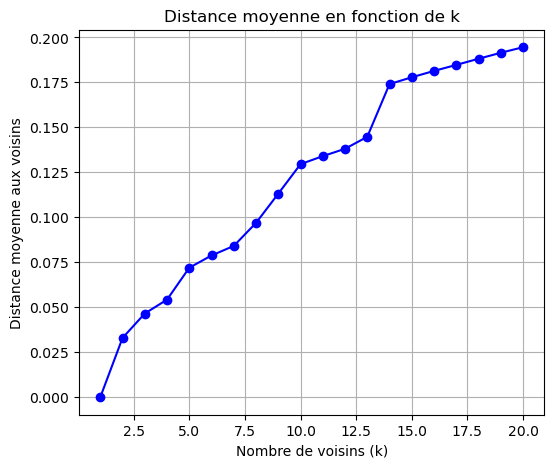

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Fonction pour évaluer différentes valeurs de k
def evaluate_k(X_encoded, k_range):
    avg_distances = []

    for k in k_range:
        # Modèle Nearest Neighbors
        model = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
        model.fit(X_encoded)

        # Moyenne des distances aux k plus proches voisins
        distances, _ = model.kneighbors(X_encoded)
        avg_distance = distances[:, -1].mean()  # Moyenne de la dernière colonne (k-ème distance)
        avg_distances.append(avg_distance)

    return avg_distances

# Définition de la plage de k à tester
k_range = range(1, 21)  # Test des valeurs de k de 1 à 20

# Évaluation des différentes valeurs de k
X_sample = X[:1000]  # Limiter à un sous-échantillon pour accélérer
avg_distances = evaluate_k(X_sample, k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(6, 5))
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)
plt.show()

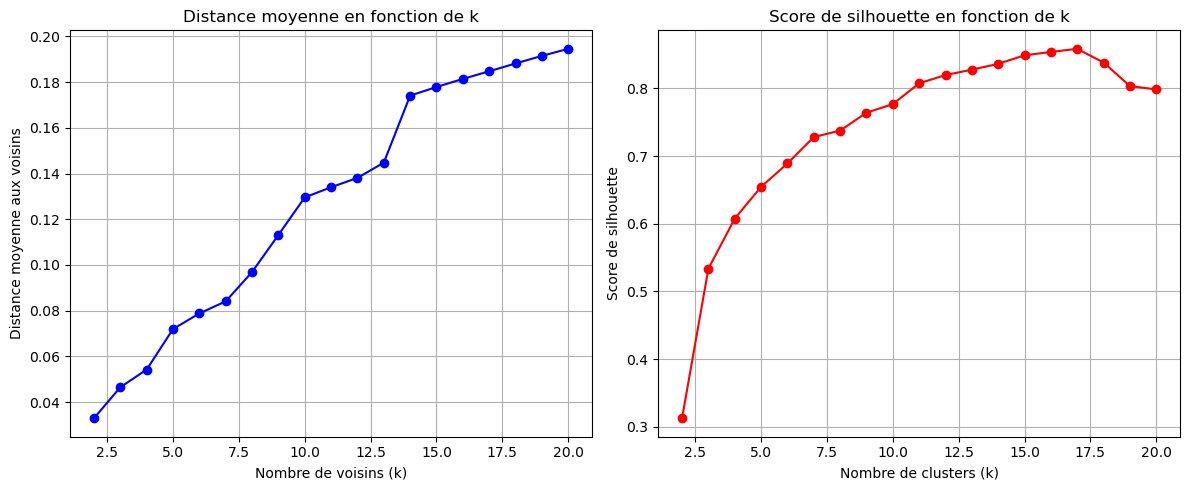

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def evaluate_k_with_silhouette(X_encoded, k_range):
    avg_distances = []
    silhouette_scores = []

    for k in k_range:
        # Modèle Nearest Neighbors
        model = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
        model.fit(X_encoded)

        # Moyenne des distances aux k plus proches voisins
        distances, _ = model.kneighbors(X_encoded)
        avg_distance = distances[:, -1].mean()
        avg_distances.append(avg_distance)

        # Clustering avec K-Means pour silhouette_score
        if k > 1:
            kmeans = KMeans(n_clusters=k, random_state=42).fit(X_encoded)
            labels = kmeans.labels_
            silhouette = silhouette_score(X_encoded, labels)
            silhouette_scores.append(silhouette)
        else:
            silhouette_scores.append(0)

    return avg_distances, silhouette_scores

# Définition de la plage de k à tester
k_range = range(2, 21)  # K-Means nécessite au moins k=2

# Évaluation des distances moyennes et du score de silhouette
avg_distances, silhouette_scores = evaluate_k_with_silhouette(X_sample, k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(12, 5))

# Premier graphique : Distance moyenne aux voisins
plt.subplot(1, 2, 1)
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)

# Second graphique : Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de k')
plt.grid(True)

plt.tight_layout()
plt.show()


In [100]:
df_filtered.head()


,popularity,vote_average,vote_count,budget,revenue,runtime,genres,title,two_actors
0,1.930,7.738,21,0,0,15,Drama,Sunday in August,['Marc Meyer']
1,68.898,7.823,17625,94000000,940335536,100,Animation,Finding Nemo,"['Ellen DeGeneres', ' Thomas Vicari']"
2,13.781,7.881,1555,12800000,40031879,141,Drama,Dancer in the Dark,"['Catherine Deneuve', ' Joel Grey']"
3,7.178,5.815,232,0,6593579,87,Horror,The Dark,"['Steve Allaway', ' Johnny Bamford']"
4,11.068,5.880,403,2500000,12300000,106,Drama,My Life Without Me,"['Debbie Harry', ' Sarah Polley']"


In [99]:
# Récupérer les acteurs du film recherché
film_actors = df_filtered2.loc[df_filtered2['title'] == 'Avatar', 'two_actors']

# Vérifier si le film existe
if film_actors.empty:
    f"Le film '{film_nom}' n'existe pas dans la base."

# Extraire les acteurs sous forme de liste
film_actors_list = list(film_actors.iloc[0])  # Les acteurs du film recherché

# # Filtrer les films ayant au moins un acteur commun
# df_actorF = df[df['two_actors'].apply(
# lambda x: any(actor in x for actor in film_actors_list)
# )]

# # Vérifier si des films sont disponibles après le filtrage
# if df_actorF.empty:
# return f"Aucun film trouvé avec des acteurs similaires à '{film_nom}'."


# # Préparer les caractéristiques pour le modèle Nearest Neighbors
# features = ['popularity', 'vote_average', 'vote_count', 'budget', 'revenue', 'runtime']

# # Vérifier que toutes les colonnes nécessaires sont présentes
# if not all(feature in df_actorF.columns for feature in features):
# return "Certaines colonnes nécessaires pour les calculs sont manquantes."

# # Normaliser les données
# scaler = MinMaxScaler()
# X = scaler.fit_transform(df_actorF[features])

# # Initialiser le modèle Nearest Neighbors
# model = NearestNeighbors(n_neighbors=6, metric='euclidean')
# model.fit(X)

# # Rechercher l'index du film donné
# film_index = df_actorF[df_actorF['title'].str.lower() == film_nom.lower()].index
# if len(film_index) == 0:
# return f"Le film '{film_nom}' n'est pas dans la base filtrée."

# # Trouver les films similaires
# distances, indices = model.kneighbors([X[film_index[0]]])

# # Retourner les films similaires
# resultats = []
# for i, idx in enumerate(indices[0][1:], start=1):  # Exclure le film d'origine
# film_title = df_actorF.iloc[idx]['title']

# # Récupérer le lien depuis df_tmdb
# lien_poster = df_tmdb[df_tmdb['title'] == film_title]['poster_path'].values
# imdb_id = df_tmdb[df_tmdb['title'] == film_title]['imdb_id'].values

# resultats.append({
#     "title": film_title,
#     "poster_path": lien_poster[0] if len(lien_poster) > 0 else None,
#     "imdb_id": imdb_id[0] if len(imdb_id) > 0 else None
# })

# return resultats

# except Exception as e:
# return f"Erreur lors du traitement : {e}"


